In [2]:
import os
import dask.dataframe as dd
import numpy as np
import pandas as pd
import yfinance as yf
from itertools import combinations
from math import sqrt, log
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from concurrent.futures import ThreadPoolExecutor
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint

# Functions

## Coint, OU params

In [30]:
def download_data(stock1, stock2, start_date):
    df1 = yf.download(stock1, start = start_date)
    df2 = yf.download(stock2, start = start_date)
    common_dates = df1.index.intersection(df2.index)
    df1 = df1.loc[common_dates]
    df2 = df2.loc[common_dates]

    if not check_coint(df1, df2):
        print("無共整合")
    
    return pd.DataFrame(df1), pd.DataFrame(df2)

# 檢查是否共整合
def check_coint(df1, df2):
    def adf_test(series):
        result = adfuller(series)
        p_value = result[1]
        return p_value < 0.1

    price_ratio = df1['Close'] / df2['Close']
    is_stationary = adf_test(price_ratio)

    score, p_value, _ = coint(df1['Close'], df2['Close'])
    is_coint = p_value < 0.1

    if is_stationary and is_coint:
        return True
    else:
        return False

# 得到OU model的參數
def ou_params(spread):
    n = len(spread)
    delta_t = 1
    spread_diff = np.diff(spread)
    spread_lag = spread[:-1]

    def negative_log_likelihood(params):
        mu, theta, sigma = params
        residual = spread_diff - theta * (mu - spread_lag) * delta_t
        variance = sigma ** 2 * (1 - np.exp(-2 * theta * delta_t)) / (2 * theta)
        log_likelihood = (
            -0.5 * n * np.log(2 * np.pi)
            - 0.5 * n * np.log(variance)
            - (residual ** 2).sum() / (2 * variance)
        )
        return -log_likelihood

    initial_params = [np.mean(spread), 0.1, np.std(spread)]
    bounds = [(None, None), (1e-5, None), (1e-5, None)]

    result = minimize(negative_log_likelihood, initial_params, bounds=bounds)

    if not result.success:
        return np.nan, np.nan, np.nan

    mu, theta, sigma = result.x

    # 會有這裡是因為theta有負數，如果是共整合還會有負數嗎？
    min_theta = max(1e-5, np.std(spread) / 100)
    theta = max(theta, min_theta)

    return mu, theta, sigma

def calculate_spread(test_df1, test_df2, i):
    hedge_ratio = sm.OLS(test_df1.loc[:i, 'Close'], test_df2.loc[:i, 'Close']).fit().params.iloc[0]
    spread = test_df1.loc[i, 'Close'] - hedge_ratio * test_df2.loc[i, 'Close']
    return spread



## Return

In [4]:
def calculate_log_return(current_price1, current_price2, previous_price1, previous_price2):
    ratio_now = current_price1 / current_price2
    ratio_prev = previous_price1 / previous_price2
    log_return = np.log(ratio_now / ratio_prev)
    return log_return

def cumulate_return(ret_df):
    ret_df['cum_ret'] = (1 + ret_df['log_ret']).cumprod() - 1
    return ret_df

def generate_ret(signal_df, df1, df2):
    ret_df = pd.DataFrame(index = signal_df.index, columns = ['position', 'calculate_log_return'])
    ret_df['position'] = 0
    ret_df['log_ret'] = 0.0
    
    for i in ret_df.index:
    
        try:
            next_date = signal_df.index[signal_df.index.get_loc(i) + 1]
        except:
            next_date = i

        signal = signal_df.loc[i, 'signal']
        position = ret_df.loc[i, 'position']

        if position == 0:
            if signal == 1:
                position += 1
            elif signal == -1:
                position -= 1
        elif position != 0:
            if signal == 0:
                if position > 0:
                    position -= 1
                else:
                    position += 1

        ret_df.loc[next_date, 'position'] = position

        if position != 0:
            previous_price1 = df1.loc[i, 'Open']
            previous_price2 = df2.loc[i, 'Open']
            current_price1 = df1.loc[next_date, 'Open']
            current_price2 = df2.loc[next_date, 'Open']

            if position == 1:  # Long stock2, Short stock1
                log_ret = calculate_log_return(current_price2, current_price1, previous_price2, previous_price1)
            elif position == -1:  # Short stock2, Long stock1
                log_ret = calculate_log_return(current_price1, current_price2, previous_price1, previous_price2)

            ret_df.loc[next_date, 'log_ret'] = log_ret

        ret_df = cumulate_return(ret_df)
    return ret_df


## Main function

In [ ]:
# 以下是rolling window的過程
def execute(df1, df2, window_size = 100, insample_ratio = 0.5, holding_period_limit = 50):
    step_size = int(window_size * (1 - insample_ratio))
    signal_df = pd.DataFrame(columns = ['spread', 'theta', 'mu', 'sigma', 'signal'])
    holiding_counter = 0
    stop_loss_zscore = 3

    for start in range(0, len(df1) - window_size + 1, step_size):
        end = int(start + window_size)
        in_sample_end = int(start + window_size * insample_ratio)

        train_df1 = df1.loc[df1.index[start: in_sample_end]]
        train_df2 = df2.loc[df2.index[start: in_sample_end]]

        if not check_coint(train_df1, train_df2):
            print(f" {start} 到 {start + step_size} 無共整合")
            # continue
        else:
            print(f" {start} 到 {start + step_size} 共整合")

        test_df1 = df1.loc[df1.index[in_sample_end: end]]
        test_df2 = df2.loc[df2.index[in_sample_end: end]]

        for i in test_df1.index:
            signal_df.loc[i, 'spread'] = calculate_spread(test_df1, test_df2, i)

            start_index = i - pd.DateOffset(days = window_size * (1 - insample_ratio))
            mu, theta, sigma = ou_params(signal_df.loc[start_index: i, 'spread'])
            
            signal_df.loc[i, 'theta'] = theta
            signal_df.loc[i, 'mu'] = mu
            signal_df.loc[i, 'sigma'] = sigma
            
            if signal_df.loc[i, 'theta'] > 0:
                sqrt_value = np.sqrt(2 / theta)
                signal_df.loc[i, 'a'] = mu + sigma * sqrt_value
                signal_df.loc[i, 'b'] = mu - sigma * sqrt_value
            else:
                signal_df.loc[i, 'a'] = np.nan
                signal_df.loc[i, 'b'] = np.nan

            long =  signal_df.loc[i, 'spread'] < signal_df.loc[i, 'b']
            short =  signal_df.loc[i, 'spread'] > signal_df.loc[i, 'a']
        
        zscore = (signal_df.loc[i, 'spread'] - mu) / sigma
        
        if abs(zscore) >= stop_loss_zscore:
            signal_df.loc[i, 'signal'] = 0
        elif long:
            signal_df.loc[i, 'signal'] = 1
        elif short:
            signal_df.loc[i, 'signal'] = -1
        
        if signal_df.loc[i, 'signal'] != 0:
            holiding_counter += 1
        else:
            holiding_counter = 0

        if holiding_counter > holding_period_limit:
            signal_df.loc[signal_df.index[i], 'signal'] = 0

    return signal_df

In [58]:
import yfinance as yf
from statsmodels.tsa.stattools import coint, adfuller
import pandas as pd

# 定義檢查共整合的函數
def check_coint(df1, df2):
    def adf_test(series):
        series = series.dropna()  # 去除空值
        if len(series) == 0:
            return False  # 如果series全是空，直接返回False
        result = adfuller(series)
        p_value = result[1]
        return p_value < 0.1  # ADF檢定的p值是否小於顯著水平

    # 計算價格比
    price_ratio = df1['Close'] / df2['Close']
    price_ratio = price_ratio.dropna()  # 確保無NaN值

    # 檢查價格比是否平穩
    is_stationary = adf_test(price_ratio)

    # 共整合檢定
    score, p_value, _ = coint(df1['Close'], df2['Close'])
    is_coint = p_value < 0.1  # 共整合檢定的p值是否小於顯著水平

    # 返回共整合結果
    return is_stationary and is_coint

# 下載數據
df3017 = yf.download('3017.TW', start='2023-01-01', end='2024-12-17')
df3324 = yf.download('3324.TWO', start='2023-01-01', end='2024-12-17')

# 設定切片大小
step_size = 53

# 檢查共整合
for start in range(0, len(df3017), step_size):
    # 確定切片範圍
    in_sample_end = min(start + step_size, len(df3017))  # 確保不超出範圍

    # 使用iloc進行切片
    train_df1 = df3017.iloc[start:in_sample_end]
    train_df2 = df3324.iloc[start:in_sample_end]

    # 獲取日期範圍
    start_date = train_df1.index[0].strftime('%Y-%m-%d')
    end_date = train_df1.index[-1].strftime('%Y-%m-%d')

    # 檢查是否共整合
    if not check_coint(train_df1, train_df2):
        print(f"日期範圍：{start_date} 到 {end_date} 無共整合")
    else:
        print(f"日期範圍：{start_date} 到 {end_date} 共整合")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

日期範圍：2023-01-03 到 2023-03-30 共整合
日期範圍：2023-03-31 到 2023-06-19 無共整合
日期範圍：2023-06-20 到 2023-09-05 無共整合
日期範圍：2023-09-06 到 2023-11-22 無共整合
日期範圍：2023-11-23 到 2024-02-15 無共整合
日期範圍：2024-02-16 到 2024-05-06 無共整合
日期範圍：2024-05-07 到 2024-07-19 無共整合
日期範圍：2024-07-22 到 2024-10-09 無共整合
日期範圍：2024-10-11 到 2024-12-16 共整合


In [59]:
from scipy.stats import pearsonr

close_3017 = df3017['Close']
close_3324 = df3324['Close']

correlation, p_value = pearsonr(close_3017, close_3324)

print(f"Pearson Correlation: {correlation}")
print(f"P-value: {p_value}")

Pearson Correlation: 0.9673957628599427
P-value: 2.868857557113315e-281


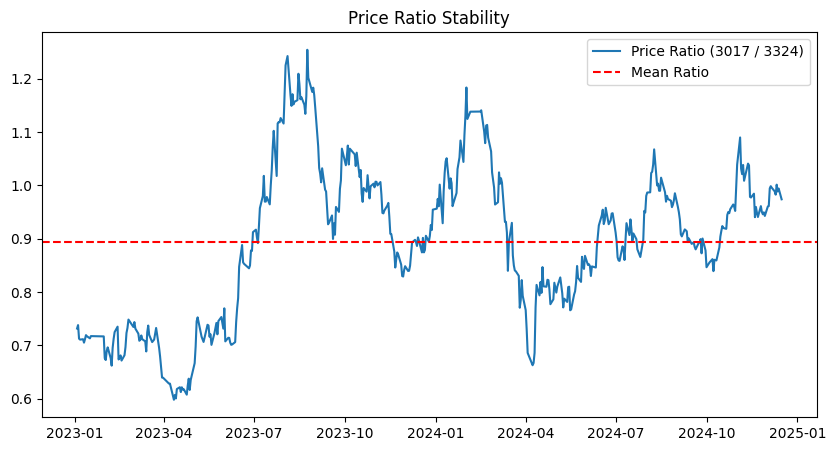

In [60]:
import matplotlib.pyplot as plt

price_ratio = close_3017 / close_3324

plt.figure(figsize=(10, 5))
plt.plot(price_ratio, label='Price Ratio (3017 / 3324)')
plt.axhline(price_ratio.mean(), color='red', linestyle='--', label='Mean Ratio')
plt.title('Price Ratio Stability')
plt.legend()
plt.show()

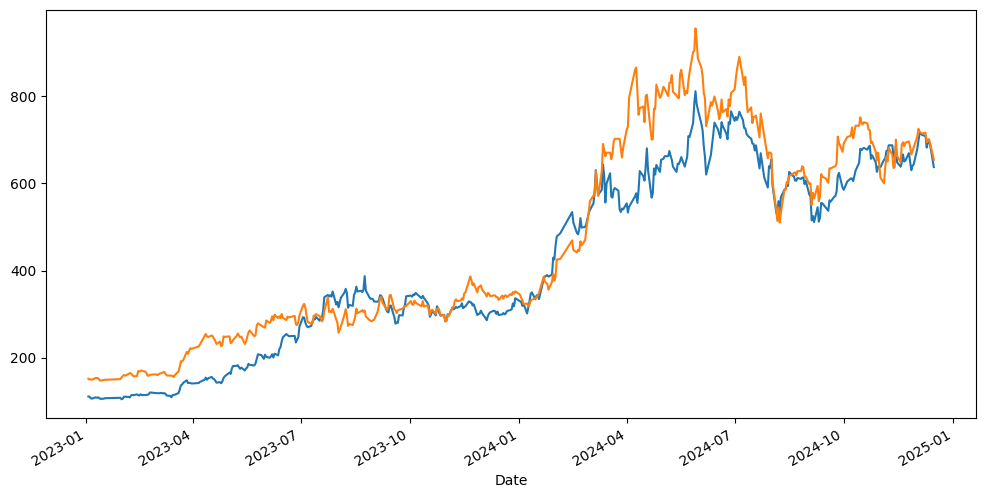

In [34]:
plt.figure(figsize = (12, 6))
df3017['Close'].plot()
df3324['Close'].plot()
plt.show()

# params

In [29]:
window_size = 200
train_ratio = 0.7
holding_period_limit = 50
start_date = "2000-01-01"


In [25]:
'''
我的做法是先透過execute得到訊號，再透過訊號計算報酬
只是成本還沒加上去
'''

df1, df2 = download_data("0050.TW", "^TWII", start_date)
signal_df = execute(df1, df2, window_size, train_ratio)


NameError: name 'start_date' is not defined

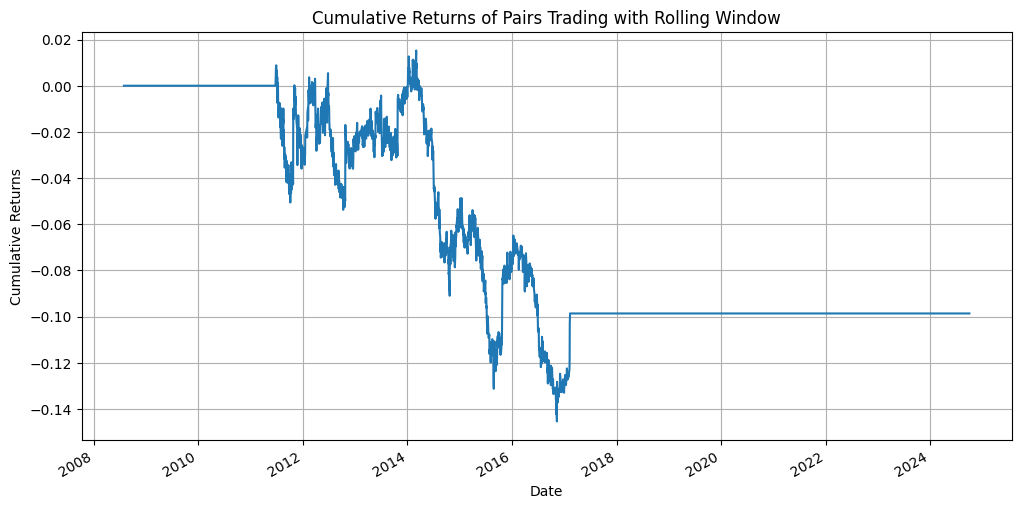

In [ ]:
ret_df = generate_ret(signal_df, df1, df2)

plt.figure(figsize = (12, 6))
ret_df['cum_ret'].plot(title = "Cumulative Returns of Pairs Trading with Rolling Window")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

In [32]:
signal_df.to_csv('/Users/xinc./Documents/GitHub/Quant/TMBA/Pairs/signal_df.csv')
ret_df.to_csv('/Users/xinc./Documents/GitHub/Quant/TMBA/Pairs/ret_df.csv')